In [3]:
from model.utils import timestep_embedding, timesteps_to_tensor
import torch.nn.functional as F

from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily, MultivariateNormal
import torch
#device = 'mps'
# device = 'cuda:0'
device = 'cpu'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

# SDE-based diffusion models with ToyNet generator

In [6]:
class ResNet_FC(nn.Module):
    def __init__(self, data_dim, hidden_dim, num_res_blocks):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.map=nn.Linear(data_dim, hidden_dim)
        self.res_blocks = nn.ModuleList(
            [self.build_res_block() for _ in range(num_res_blocks)])

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        return linear

    def build_res_block(self):
        hid = self.hidden_dim
        layers = []
        widths =[hid]*4  # [256, 256, 256, 256]
        for i in range(len(widths) - 1):
            layers.append(self.build_linear(widths[i], widths[i + 1]))
            layers.append(nn.SiLU())
        return nn.Sequential(*layers) # [batch_size, dim]

    def forward(self, x):  # x_t: [batch_size, data_dim]
        h=self.map(x)
        for res_block in self.res_blocks:
            h = (h + res_block(h)) / np.sqrt(2)
        return h   # [batch_size, dim]

In [8]:
class ToyNet(nn.Module):
    def __init__(self, data_dim, direction=None):
        super(ToyNet, self).__init__()
        self.direction = direction

        self.time_embed_dim = 128
        dim = 256
        out_dim = data_dim

        self.t_module = nn.Sequential(nn.Linear(self.time_embed_dim, dim), nn.SiLU(), nn.Linear(dim, dim),)
        self.x_module = ResNet_FC(data_dim, dim, num_res_blocks=1)
        self.out_module = nn.Sequential(nn.Linear(dim,dim), nn.SiLU(), nn.Linear(dim, out_dim),)
        
    def forward(self, x, t: int or list[int]): # x_t: [batch_size, data_dim]
        t = timesteps_to_tensor(t, batch_size=x.shape[0]).to(x.device)
        t_emb = timestep_embedding(t, self.time_embed_dim)  # [batch_size, time_embed_dim]

        t_out = self.t_module(t_emb) # [batch_size, dim=256]
        x_out = self.x_module(x) # [batch_size, dim=256]
        out   = self.out_module(x_out+t_out) # [batch_size, out_dim=data_dim]

        return out

In [9]:
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t # [N]

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device) # [N,d=1]
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.) 

        return x_prev # [N,d=1]

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise # [N,1]
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data): # data: torch.tensor, shape=[N]
        trajs = torch.zeros([len(data), self.total_steps+1]) # [N, T+1]
        x = data.to(device) # [N]
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t) # [N]
            trajs[:, t] = x
        return x, trajs # [N], [N, T+1]
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise # [N,d=1]
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs) # [N,d=1], [N,(T+1)*d]
        
    def backward_sample_example(self, noise, net):
        """
        Sample from backward diffusion process
        noise: torch.tensor, shape=[num_paths, T]
        """
        # noise_start = noise[:, 0]
        noise_end = noise[:, -1]
        # trajs = [noise_end]
        trajs = torch.zeros_like(noise)
        trajs[:, -1] = noise_end
        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(noise[:,t].unsqueeze(1), t) # [N,d=1]
            x_t = self.backward_one_step(noise[:,t].unsqueeze(1), t, pred_score)
            trajs[:,t-1] = x_t.squeeze()
        return x_t, trajs


In [10]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


<class 'torch.distributions.mixture_same_family.MixtureSameFamily'>
torch.Size([])
torch.Size([])


In [11]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

In [12]:
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [13]:
x_data = data_dist.sample([num_paths]).to(device)
x_noise, traj_forward = diffusion.forward_sample(x_data)

In [14]:
num_epochs = 2000
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x0 = data_dist.sample([num_paths]).to(device)
    t = np.random.randint(1, total_steps + 1)
    loss = loss_function(x0.view(-1 ,1), diffusion, score_net, t)
    loss.backward()
    opt.step()
    if(i%50==0):
        x0 = data_dist.sample([num_paths]).to(device)
        t = np.random.randint(1, total_steps + 1)
        loss = loss_function(x0.view(-1 ,1), diffusion, score_net, t)
        loss.backward()
        opt.step()
    if(i%50==0):
        print(i, loss)

0 tensor(5.7106, grad_fn=<DivBackward0>)
50 tensor(2.5226, grad_fn=<DivBackward0>)
100 tensor(25.9360, grad_fn=<DivBackward0>)
150 tensor(0.6248, grad_fn=<DivBackward0>)
200 tensor(1.8188, grad_fn=<DivBackward0>)
250 tensor(0.5533, grad_fn=<DivBackward0>)
300 tensor(0.3197, grad_fn=<DivBackward0>)
350 tensor(0.2433, grad_fn=<DivBackward0>)
400 tensor(3.8126, grad_fn=<DivBackward0>)
450 tensor(2.5248, grad_fn=<DivBackward0>)
500 tensor(1.3494, grad_fn=<DivBackward0>)
550 tensor(5.2805, grad_fn=<DivBackward0>)
600 tensor(0.1382, grad_fn=<DivBackward0>)
650 tensor(2.4093, grad_fn=<DivBackward0>)
700 tensor(0.3674, grad_fn=<DivBackward0>)
750 tensor(0.1854, grad_fn=<DivBackward0>)
800 tensor(12.7764, grad_fn=<DivBackward0>)
850 tensor(0.0348, grad_fn=<DivBackward0>)
900 tensor(4.0825, grad_fn=<DivBackward0>)
950 tensor(11.4349, grad_fn=<DivBackward0>)
1000 tensor(3.2492, grad_fn=<DivBackward0>)
1050 tensor(4.2436, grad_fn=<DivBackward0>)
1100 tensor(0.0701, grad_fn=<DivBackward0>)
1150 ten

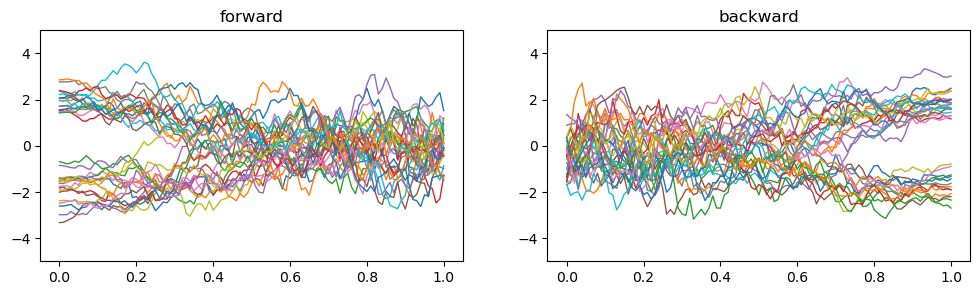

In [15]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

# local PCFD as loss function as ToyNet as generator

In [16]:
pcf = PCF_with_empirical_measure(8, 5, 1, add_time=True)
pcf = pcf.to(device)
num_paths = 64
G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-4, betas=(0.9, 0.999))
D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.9, 0.999))
n_Dstep_per_Gstep = 10
n_Gstep_per_Dstep = 1
t_max_step = 80

num_epochs = 5
ts_length = 20
forecast_length = 20

for i in range(num_epochs):
    x_data = data_dist.sample([num_paths]) # [N]
    x_noise, traj_forward = diffusion.forward_sample(x_data) # [N, total_steps+1]
    traj_forward = traj_forward.to(device) # [N, total_steps+1]
    traj_forward_flip = torch.fliplr(traj_forward)
             
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
   
        #x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net)
        #x_gen, traj_back = diffusion.backward_sample(x_noise.to(device), score_net)

    for j in range(n_Gstep_per_Dstep):  
        with torch.no_grad():
            x_gen, traj_back = diffusion.backward_sample_example(traj_forward.to(device), score_net)
            t = torch.randint(t_max_step, (ts_length,))    
    
            x_real=traj_forward_flip.view([-1,total_steps+1, 1]) # [N, total_steps+1, 1]
            x_fake = traj_back.view([-1, total_steps+1, 1]) # [N, total_steps+1, 1]
        G_loss = 0
        for t1 in range(ts_length):
            G_loss = G_loss + pcf.distance_measure(x_real[:, [t1, t1+forecast_length]], 
                                x_fake[:, [t1,  t1+forecast_length]], Lambda=0.1) 
        G_loss = G_loss/ts_length
        G_opt.zero_grad()
        G_loss.backward()
        torch.nn.utils.clip_grad_norm_(score_net.parameters(), 0.05)

        G_opt.step()
        pcf.eval()  # Set PCF model to evaluation mode
        print(j,  G_loss.item())
        
    for j in range(n_Dstep_per_Gstep):
        with torch.no_grad():
            x_data = data_dist.sample([num_paths])
            x_noise, traj_forward = diffusion.forward_sample(x_data)
            traj_forward = traj_forward.to(device)
            x_gen, traj_back = diffusion.backward_sample(torch.randn([num_paths, 1]).to(device), score_net) 
        traj_forward_flip = torch.fliplr(traj_forward)
       # G_loss =  pcf.distance_measure(traj_forward_flip.view([-1, total_steps+1, 1]), 
                               # traj_back.view([-1, total_steps+1, 1]), Lambda=0) 
           
        x_real=traj_forward_flip.view([-1,total_steps+1, 1])
        x_fake = traj_back.view([-1, total_steps+1, 1])
        pcf.train()  # Set PCF model to training mode
    #D_loss = -pcf.distance_measure(traj_forward_flip.view([-1,  total_steps+1, 1]), 
                               # traj_back.view([-1, total_steps+1, 1]), Lambda=0.0) 
        t = torch.randint(t_max_step, (ts_length,)) 
        D_loss = 0
        for t1 in range(ts_length):
            D_loss = D_loss - pcf.distance_measure(x_real[:, [t1, t1+forecast_length]], 
                                x_fake[:, [t1,  t1+forecast_length]], Lambda=0.1) 
        D_loss =  D_loss/ts_length

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        pcf.eval()  # Set PCF model to evaluation mode
        print(j, D_loss.item())
    


0 1.1755605936050415
0 -0.1391019970178604
1 -0.12642301619052887
2 -0.16656409204006195
3 -0.13371706008911133
4 -0.10067625343799591
5 -0.29417550563812256
6 -0.08878519386053085
7 -0.13294579088687897
8 -0.11541853100061417
9 -0.13990378379821777
0 1.0589373111724854
0 -0.14871658384799957
1 -0.15016889572143555
2 -0.17493991553783417
3 -0.11163000762462616
4 -0.11104706674814224
5 -0.2054348886013031
6 -0.08991976827383041
7 -0.10556201636791229
8 -0.1470053493976593
9 -0.1260601282119751
0 1.1822407245635986
0 -0.23448137938976288
1 -0.14459946751594543
2 -0.09807918965816498
3 -0.15460124611854553
4 -0.15935225784778595
5 -0.15685029327869415
6 -0.09515997022390366
7 -0.13247524201869965
8 -0.14711812138557434
9 -0.1081559881567955
0 1.374002456665039
0 -0.16059502959251404
1 -0.1544482707977295
2 -0.11729119718074799
3 -0.13314028084278107
4 -0.1174275279045105
5 -0.1327114850282669
6 -0.1434973180294037
7 -0.11491908133029938
8 -0.0909276157617569
9 -0.17732660472393036
0 1.376

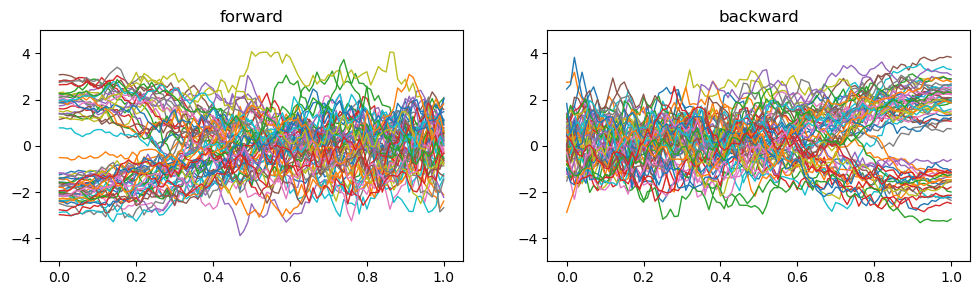

In [18]:
xxx = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))

plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)
    
plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)


for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()

# local PCFD as loss function and SigRNN as generator

In [ ]:
class FFN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dims: Tuple[int]):
      super().__init__()      
      blocks = []
      input_dim_block = input_dim

      for hidden_dim in hidden_dims:
          blocks.append(nn.Linear(input_dim_block, hidden_dim))
          blocks.append(nn.PReLU())
          input_dim_block = hidden_dim
      blocks.append(nn.Linear(input_dim_block, output_dim))
      self.network = nn.Sequential(*blocks)
      self.output_dim = output_dim

    def forward(self, *args):
      x = torch.cat(args, -1)
      out = self.network(x)
      return out

In [ ]:
class OneStepGenerator(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim=1):
    super(OneStepGenerator, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    self.ffn = FFN(input_dim=input_dim+1+2*input_dim,output_dim=output_dim,hidden_dims=[hidden_dim, hidden_dim])

  # generate i.i.d. d=input_dim joint Gaussian rvs with defined covariance matrix
  def sample_eps(self, batch_size, input_dim,c_dt):
    eps = []
    for _ in range(input_dim):
      cov_matrix = torch.tensor([[c_dt, (c_dt**2/2)],
                              [(c_dt**2/2), (c_dt**3/3)]])
      m = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=cov_matrix)
      eps_i = m.sample((batch_size,input_dim)) #
      eps.append(eps_i)
    eps = torch.cat(eps, dim=1) # [N, 2*input_dim]
    return eps # [N, 2*input_dim]

  def forward(self, x_t, t, c_dt): # x_t: [N,d=1]
    eps = self.sample_eps(batch_size=x_t.shape[0],input_dim=x_t.shape[1],c_dt=c_dt).to(device) # [N,2*d=2]
    
    t_tensor = torch.tensor([t]).unsqueeze(0).repeat(x_t.shape[0],1).to(device) # [N,1]
    out = self.ffn(torch.cat((x_t,t_tensor,eps), dim=1)) # [N,in+2*in+1]

    return out # [N,output_dim=1]


In [ ]:
class SigRNNDiffusion(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}},
                 ratio,
                 **kwargs):
        super(SigRNNDiffusion, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps
        self.ratio = ratio # number of steps per coarse time step
        self.sde = SDE(self.total_steps, sde_type, sde_info)

    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation:
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t # [N]

    def forward_sample(self, data): # data: torch.tensor, shape=[N]
        trajs = torch.zeros([len(data), self.total_steps+1]) # [N,T+1]
        x = data.to(device) # [N]
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t) # [N]
            trajs[:, t] = x
        return x.unsqueeze(1), trajs # [N]->[N,d=1] the last, [N,T+1]

    def backward_one_coarse_step(self, x_t, t, c_dt, generator, clip_denoised=True):
      x_prev = generator(x_t, t, c_dt)
      if clip_denoised and x_t.ndim > 2:
        print('backward_one_step')
        x_prev.clamp_(-1., 1.)
      return x_prev # [N,d=1]

    @torch.no_grad()
    def sample(self, x_t, t_end:int, forecast_tsteps:int, c_per_tsteps:int, generator):
      """
      Sample from backward diffusion process
      """
      x_t = x_t.to(device) # [N,d=1]
      trajs = [x_t]
      forecast_csteps = math.ceil(forecast_tsteps/c_per_tsteps)
      coarse_time_partition = torch.linspace((t_end-forecast_tsteps+c_per_tsteps)*self.dt, t_end*self.dt, forecast_csteps)
      c_dt = c_per_tsteps*self.dt
      for t in reversed(coarse_time_partition):
        x_t = self.backward_one_step(x_t,t,c_dt,generator) # [N,d=1]
        trajs.append(x_t)
      return x_t, torch.hstack(trajs) # [N,d=1], [N,(c_T+1)*(d=1)]

    def backward_sample(self, x_t, t_index:int, forecast_csteps:int, generator):
      """
      Sample from backward diffusion process
      """
      x_t = x_t.to(device) # [N,d=1]
      trajs = [x_t]
      forecast_csteps = math.ceil(forecast_tsteps/c_per_tsteps)
      coarse_time_partition = torch.linspace((t_end-forecast_tsteps+c_per_tsteps)*self.dt, t_end*self.dt, forecast_csteps)
      c_dt = c_per_tsteps*self.dt
      for t in reversed(coarse_time_partition):
        x_t = self.backward_one_coarse_step(x_t,t,c_dt,generator) # [N,d=1]
        trajs.append(x_t)
      return x_t, torch.hstack(trajs) # [N,d=1], [N,(c_T+1)*(d=1)]



In [ ]:
total_steps = 100

pcf = PCF_with_empirical_measure(8, 5, 1, add_time=True)  # PCFD
pcf = pcf.to(device)

generator = OneStepGenerator(input_dim=1, hidden_dim=256, output_dim=1).to(device)
diffusion_sigrnn = SigRNNDiffusion(discrete=False, total_steps=total_steps, sde_type="VP")

batch_size = 64
num_epochs = 10
G_opt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.99, 0.999))
D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-3, betas=(0.99, 0.999))

n_Dstep_per_Gstep = 1
n_Gstep_per_Dstep = 10

ts_length = 10
ratio = 4
forecast_csteps = 5

for i in range(num_epochs):
  x_data = data_dist.sample([batch_size])
  _, traj_forward = diffusion_sigrnn.forward_sample(x_data)
  traj_forward = traj_forward.to(device)

  # train the SigRNN Generator
  for j in range(n_Gstep_per_Dstep):
    ts = torch.randint(forecast_tsteps,total_steps,(ts_length,))
    G_loss = 0
    for t_end in ts:
      t_start = t_end-forecast_tsteps
      x_gen, traj_back = diffusion_sigrnn.backward_sample(traj_forward[:,t_end].unsqueeze(1).to(device),
                                                          t_end=t_end, forecast_tsteps=forecast_tsteps, c_per_tsteps=c_per_tsteps,
                                                          generator=generator)
      traj_back = traj_back.to(device)
      x_real = torch.fliplr(traj_forward[:,t_start:t_end+1:c_per_tsteps]).view([-1, forecast_csteps+1, 1])
      x_fake = traj_back.view([-1, forecast_csteps+1, 1])
      G_loss = G_loss + pcf.distance_measure(x_real, x_fake, Lambda=0.1)

    G_loss = G_loss/ts_length
    G_opt.zero_grad()
    G_loss.backward()
    torch.nn.utils.clip_grad_norm_(generator.parameters(), 0.05)
    G_opt.step()
    pcf.eval()  # set PCF model to evaluation mode
    print(j,  G_loss.item())

  # train the PCF network as a discriminator. We want PCF has a great ability to distinguish the real data and the generated data.
  # so we train the PCF to maximise the distance between the real data and the generated data.
  for j in range(n_Dstep_per_Gstep):
    ts = torch.randint(forecast_tsteps,total_steps,(ts_length,))
    pcf.train()  # set PCF model to training mode
    D_loss = 0
    for t_end in ts:
      t_start = t_end-forecast_tsteps
      x_gen, traj_back = diffusion_sigrnn.backward_sample(traj_forward[:,t_end].unsqueeze(1).to(device),
                                                          t_end=t_end, forecast_tsteps=forecast_tsteps, c_per_tsteps=c_per_tsteps,
                                                          generator=generator)
      traj_back = traj_back.to(device)
      x_real = torch.fliplr(traj_forward[:,t_start:t_end+1:c_per_tsteps]).view([-1, forecast_csteps+1, 1])
      x_fake = traj_back.view([-1, forecast_csteps+1, 1])
      D_loss = D_loss - pcf.distance_measure(x_real, x_fake, Lambda=0.1)

    D_loss = D_loss/ts_length
    D_opt.zero_grad()
    D_loss.backward()
    torch.nn.utils.clip_grad_norm_(pcf.parameters(), 0.05) 
    D_opt.step()

    pcf.eval()  # set PCF model to evaluation mode
    print(j, D_loss.item())


In [ ]:
num_paths=32
x_data = data_dist.sample([num_paths]).cpu()
x_noise, traj_forward = diffusion_sigrnn.forward_sample(x_data)
time_t = np.linspace(0, 1, traj_forward.shape[1])

plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
for line in traj_forward:
    plt.plot(time_t, line.cpu(), linewidth=1.0)
    plt.title('forward')
plt.ylim(-5, 5)

plt.subplot(1, 2, 2)
x_gen, traj_back = diffusion_sigrnn.sample(torch.randn([num_paths, 1]).cpu(),
                                           t_end=total_steps, forecast_tsteps=total_steps, c_per_tsteps=c_per_tsteps,
                                           generator=generator)
time_c = np.linspace(0, 1, traj_back.shape[1])
for line in traj_back:
    plt.plot(time_c, line.cpu(), linewidth=1.0)
    plt.title('backward')
plt.ylim(-5, 5)

plt.show()